In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import h5py
import pycountry as pc
from fuzzywuzzy import fuzz
import geopandas as gp
import pickle
from itertools import product
from tqdm import tqdm_notebook as tqdm
import shapely


/Users/charlesmurphy/miniconda3/envs/fruitdor-env/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Processing of Covid-19 data in Spain provinces

Here, we show how the Covid-19 dataset in processed using the raw datasets. Two files are needed and are located in the `raw-dataset` directory of the repository:

## Number of cases
- raw file: `cases-timeseries-20210327.csv`
- processed file: `cases-timeseries.data`
- details:
  - column `provincia_iso` corresponds to the province using the [ISO 3166-2:ES] naming convention;
  - column `fecha` indicates the date in format `YYYY-MM-DD`;
  - column `num_casos` provides the number of daily new cases.
- [original file](https://cnecovid.isciii.es/covid19/resources/casos_tecnica_provincia.csv) downloaded on 2021-03-27.

In [9]:
path_to_raw = "./raw-dataset"
path_to_processed = "./processed-dataset"

provincia_data = pd.read_csv(
    f"{path_to_raw}/cases-timeseries-20210327.csv", delimiter=',', encoding="latin1", na_filter=False
)
prov_pop = pd.read_csv(
    f"{path_to_raw}/population-data.csv", encoding="latin1", delimiter=';'
)


subdiv = pc.subdivisions.get(country_code="ES")

days_and_months = {
    r"Jan. 2020":31, 
    r"Feb. 2020":29, 
    r"Mar. 2020":31, 
    r"Apr. 2020":30, 
    r"May 2020":31, 
    r"Jun. 2020":30, 
    r"Jul. 2020":31, 
    r"Aug. 2020":31, 
    r"Sep. 2020":30, 
    r"Oct. 2020":31, 
    r"Nov. 2020":30, 
    r"Dec. 2020":31, 
    r"Jan. 2021":31,
    r"Feb. 2021":28, 
    r"Mar. 2021":31
}
cumul_days = {}
c = 0
for m, d in days_and_months.items():
    cumul_days[m] = c
    c += d




Then, we collect the ISO codes of each province (`provincia_iso`), the dates (`fecha`), the number of cases (`casos`) and the population size (`Total`).

In [11]:
# Names and ISO
names = []
i = 0
for x in provincia_data["provincia_iso"]:
    if x not in names:
        names.append(x)
name_map = {}
for n in names:
    for s in subdiv:
        if n == s.code[3:]:
            name_map[n] = s
            break
        elif s.code[3:] == "ML" and n == "ME":
            name_map[n] = s
            break

# Dates
dates = []
for x in provincia_data["fecha"]:
    if x not in dates:
        dates.append(x)

# Cases
cases = {}
for i in provincia_data["num_casos"].keys():
    prov = provincia_data["provincia_iso"][i]
    date = provincia_data["fecha"][i]
    num_cases = provincia_data["num_casos"][i]
    if prov in names:
        if prov not in cases:
            cases[prov] = {date: num_cases}
        elif date not in cases[prov]:
            cases[prov][date] = num_cases
        else:
            cases[prov][date] += num_cases



Next, we format the data using numpy arrays, which we will be able to use directly for training, and save these arrays in the `processed-data` directory.

In [17]:
num_timesteps = len(dates)
num_nodes = 52

timeseries = np.zeros((num_timesteps, num_nodes))
cases_labeled = {}

for index in range(num_nodes):
    n = names[index]
    cases_labeled[n] = np.zeros(num_timesteps)
    for time in range(num_timesteps):
        d = dates[time]
        timeseries[time, index] = cases[n][d]
        cases_labeled[n][time] = cases[n][d]

path = f"{path_to_processed}/case-timeseries.data"
with open(path, "wb") as f:
    pickle.dump(timeseries, f)

## Illustration of the dataset

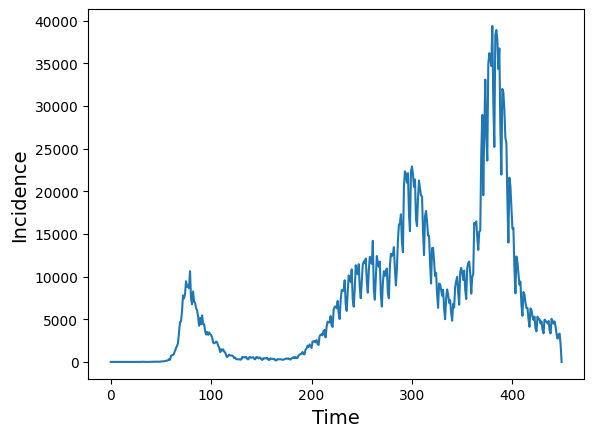

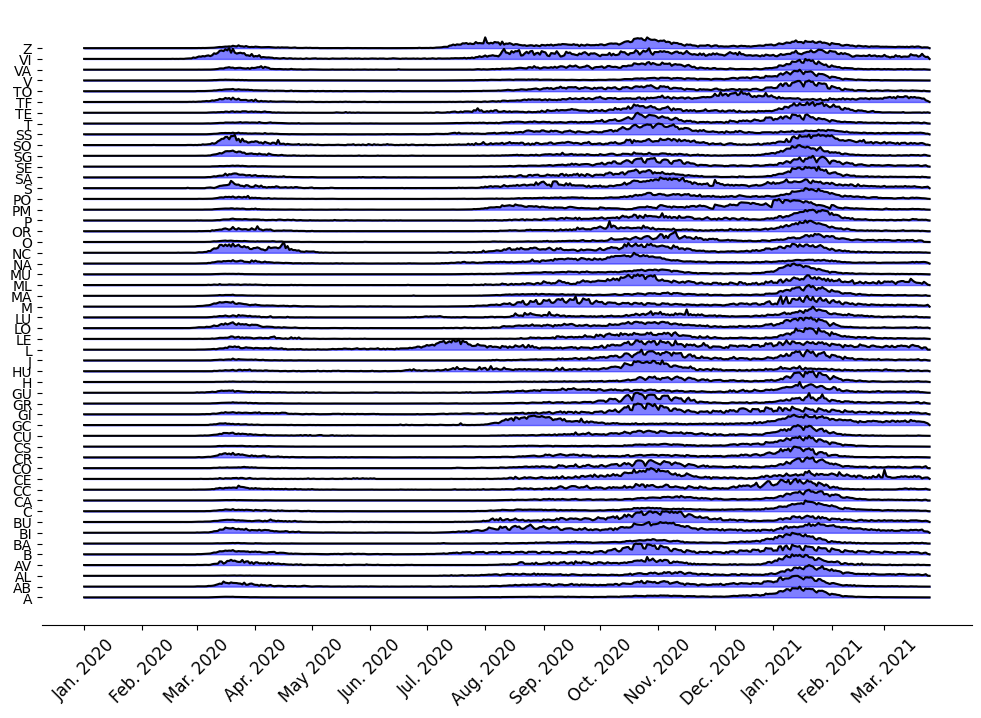

In [18]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

def ridgeline(data, x=None, overlap=0, yshift=0., color="blue", zorder=0):
    curves = []
    ys = []
    labels = []
    for i, (k, v) in enumerate(data.items()):
        labels.append(k)
        d = v / v.max() * (1. + overlap)
        if x is None:
            x = np.arange(len(d))
        y = i#*(1.0 - overlap)
        ys.append(y)

        plt.fill_between(x, np.ones(len(d))*y + yshift, d+y + yshift, zorder=zorder+len(data)-i+1, color=color, alpha=0.5)
        plt.plot(x, d+y, c='k', zorder=len(data)-i+1)
    plt.yticks(ys, labels, fontsize=10)

ax = plt.gca()
ax.plot(timeseries.sum(1))

ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Incidence', fontsize=14)
plt.show()

        
plt.figure(figsize=(12, 8))
ax = plt.gca()
ridgeline(cases_labeled, yshift=0, overlap=0., color="blue", zorder=0)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

months = list(cumul_days.keys())
ax.set_xticks(list(cumul_days.values()))
ax.set_xticklabels(months, rotation = 45, fontsize=12)
plt.show()
    

### Province population sizes
- raw file: `population-data.csv`.
- processed file: `population.data`.
- details:
  - column `Provincias` corresponds to the province name;
  - column `Total` provides the total population.
- Official data from the [Instituto Nacional de Estadística](https://www.ine.es).

In [154]:
prov_pop = pd.read_csv(
    f"{path_to_raw}/population-data.csv", encoding="latin1", delimiter=';'
)

In [155]:
name_to_iso = {
    "Albacete": "AB",
    "Alicante": "A",
    "Almeria": "AL",
    "Araba": "VI",
    "Asturias": "O",
    "Avila": "AV",
    "Badajoz": "BA",
    "Balears": "PM",
    "Barcelona": "B",
    "Bizkaia": "BI",
    "Burgos": "BU",
    "Caceres": "CC",
    "Cadiz": "CA",
    "Cantabria": "S",
    "Castellon": "CS",
    "Ciudad Real": "CR",
    "Cordoba": "CO",
    "Coruna": "C",
    "Cuenca": "CU",
    "Gipuzkoa": "SS",
    "Girona": "GI",
    "Granada": "GR",
    "Guadalajara": "GU",
    "Huelva": "H",
    "Huesca": "HU",
    "Jaen": "J",
    "Leon": "LE",
    "Lleida": "L",
    "Lugo": "LU",
    "Madrid": "M",
    "Malaga": "MA",
    "Murcia": "MU",
    "Navarra": "NA",
    "Ourense": "OR",
    "Palencia": "P",
    "Las Palmas": "GC",
    "Pontevedra": "PO",
    "La Rioja": "LO",
    "Salamanca": "SA",
    "Tenerife": "TF",
    "Segovia": "SG",
    "Sevilla": "SE",
    "Soria": "SO",
    "Tarragona": "T",
    "Teruel": "TE",
    "Toledo": "TO",
    "Valencia": "V",
    "Valladolid": "VA",
    "Zamora": "ZA",
    "Zaragoza": "Z",    
    "Ceuta": "CE",
    "Melilla": "ML",
}
iso_to_name = {v: k for k, v in name_to_iso.items()}

ac_to_iso = {
    "Andalusia": "AN",
    "Aragon": "AR",
    "Asturias": "AS",
    "Balears": "IB",
    "Basque Country": "PV",
    "Canarias": "CN",
    "Cantabria": "CB",
    "Castilla y Leon": "CL",
    "Castilla-La Mancha": "CM",
    "Catalonia": "CT",
    "Extremadura": "EX",
    "Galicia": "GA",
    "La Rioja": "RI",
    "Madrid": "MD",
    "Murcia": "MC",
    "Navarra": "NC",
    "Valencia": "VC",
    "Ceuta": "CE",
    "Melilla": "ML",
}
iso_to_ac = {v: k for k, v in ac_to_iso.items()}


In [163]:
ac_to_prov = {
    "AN": ["Almeria", "Cadiz", "Cordoba", "Granada", "Huelva", "Jaen", "Malaga", "Sevilla"],
    "AR": ["Huesca", "Teruel", "Zaragoza"],
    "AS": ["Asturias"],
    "IB": ["Balears"],
    "PV": ["Araba", "Bizkaia", "Gipuzkoa"],
    "CN": ["Las Palmas", "Tenerife"],
    "CB": ["Cantabria"],
    "CL": ["Avila", "Burgos", "Leon", "Palencia", "Salamanca", "Segovia", "Soria", "Valladolid", "Zamora"],
    "CM": ["Albacete", "Ciudad Real", "Cuenca", "Guadalajara", "Toledo"],
    "CT": ["Barcelona", "Girona", "Lleida", "Tarragona"],
    "EX": ["Badajoz", "Caceres"],
    "GA": ["Coruna", "Lugo", "Ourense", "Pontevedra"],
    "RI": ["La Rioja"],
    "MD": ["Madrid"],
    "MC": ["Murcia"],
    "NC": ["Navarra"],
    "VC": ["Alicante", "Castellon", "Valencia"],
    "CE": ["Ceuta"],
    "ML": ["Melilla"]
}
prov_to_ac_iso = {}
for ac, provs in ac_to_prov.items():
    for p in provs:
        prov_to_ac_iso[p] = ac

In [164]:
# Iso in name_to_iso are ordered the way they are in prov_pop
prov_pop["ISO"] = np.array(list(name_to_iso.values())) 
prov_pop["INE"] = prov_pop.Provincias.apply(lambda x: int(x.split(" ")[0]))
prov_pop["ProvinciaNames"] = prov_pop.Provincias.apply(lambda x: " ".join(x.split(" ")[1:]))
prov_pop["Total"] = prov_pop.Total.apply(lambda x: int(x.replace(".", "")) if isinstance(x, str) else x)
prov_pop["AutononousCommunityISO"] = prov_pop.ISO.apply(lambda x: prov_to_ac_iso[iso_to_name[x]])
prov_pop["AutononousCommunity"] = prov_pop.AutononousCommunityISO.apply(lambda x: iso_to_ac[x])
pop = dict(zip(prov_pop.ISO, prov_pop.Total))

assert len(pop) == len(iso_to_name) == 52

In [136]:
num_nodes = 52
population = np.zeros(num_nodes)

for i, (n, v) in enumerate(pop.items()):
    population[i] = v

path = f"{path_to_processed}/population.data"
with open(path, "wb") as f:
    pickle.dump(population, f)

# Province mobility network

We used mobility data from a pilot study done by the [Ministerio de Fomento](https://observatoriotransporte.mitma.gob.es/estudio-experimental) to build the weighted-multiplex mobility network.

### Mobility data
- raw files: `VI_J00.csv`, ..., `VI_J12.csv` and `VI_O00.csv`, ..., `VI_O15.csv`
- processed files: `province_mobility.data`
- details:
  - column `Origen` denotes the outbound province using the [INE's naming convention for the provinces]
  - column `Destino` denotes the inbound province using the [INE's naming convention for the provinces]
  - column `Viajeros` corresponds to the numbers of people that travel between these two autonomous communities.
- [original file](https://cdn.fomento.gob.es/portal-web-drupal/Docs_OTLE/matrices_julio_csv.zip) for July/August downloaded on 2020-08-11
- [original file](https://cdn.fomento.gob.es/portal-web-drupal/Docs_OTLE/matrices_octubre_csv.zip) for October downloaded on 2020-08-11

__Note__: The insular provinces are further subdivided into their islands:
  - 07 	Illes Balears: 07_1 Menorca, 07_2 Ibiza and 07_3 Mallorca
  - 35 Las Palmas: 35_1 Lanzarote, 35_2 Fuerteventura and 35_3 Gran Canaria
  - 38 Santa Cruz de Tenerife: 38_1 El Hierro, 38_2 Tenerife, 38_3 La Gomera and 38_4 La Palma

__Note__: more than one row may correspond to the same origin-destination pair since the original data breaks down the origin-destination journeys based on the period of the day as well as the means of transportation:
  - period of the day:
    - P1: 00:00 - 06:00
    - P2: 06:00 - 10:00
    - P3: 10:00 - 17:00
    - P4: 17:00 - 00:00
  - means of transportation:
    - roads: autobús, privado, carretera
    - seaways: barco
    - railways: tren
    - airways: avión

__Note__: numbers are represented using the Spanish convention where thousands are separated using a comma (ex: 100,000 denotes one hundred thousand)


In [168]:
ine_to_names = dict(zip(prov_pop.INE, prov_pop.ProvinciaNames))
names_to_ine = {v:k for k, v in ine_to_names.items()}
ine_to_iso = dict(zip(prov_pop.INE, prov_pop.ISO))
iso_to_ine = {v:k for k, v in ine_to_iso.items()}
ine_to_ccaa= dict(zip(prov_pop.INE, prov_pop.AutononousCommunityISO))
ccaa_to_ine= {}
for k, v in ine_to_ccaa.items():
    if v not in ccaa_to_ine:
        ccaa_to_ine[v] = [k]
    else:
        ccaa_to_ine[v].append(k)
        

After collecting the names and INE codes, we load and process the mobility data.

In [169]:
import zipfile

all_files = {}

# Loading july data
path_to_unzipped = f"{path_to_raw}/matrices_julio_csv"
with zipfile.ZipFile(f"{path_to_unzipped}.zip", 'r') as zip_ref:
    zip_ref.extractall(f"{path_to_unzipped}")
prefix = f"{path_to_unzipped}/matrices_julio/VI_J"
suffix = ".csv"
for i in range(13):
    all_files[f"J{i}"] = prefix + str(i).zfill(2) + suffix

# Loading october data
path_to_unzipped = f"{path_to_raw}/matrices_octubre_csv"
with zipfile.ZipFile(f"{path_to_unzipped}.zip", 'r') as zip_ref:
    zip_ref.extractall(f"{path_to_unzipped}")
prefix = f"{path_to_unzipped}/matrices_octubre/VI_O"
for i in range(16):
    all_files[f"O{i}"] = prefix + str(i).zfill(2) + suffix
                       
                       



def get_mobility_matrix(csvfile):
    prov_m = {
            "all":np.zeros((len(ine_to_iso), len(ine_to_iso))),
            "plane":np.zeros((len(ine_to_iso), len(ine_to_iso))),
            "car":np.zeros((len(ine_to_iso), len(ine_to_iso))),
            "bus":np.zeros((len(ine_to_iso), len(ine_to_iso))),
            "boat":np.zeros((len(ine_to_iso), len(ine_to_iso))),
            "train":np.zeros((len(ine_to_iso), len(ine_to_iso))),
        }
    ccaa_m = {
            "all":np.zeros((len(ccaa_to_ine), len(ccaa_to_ine))),
            "plane":np.zeros((len(ccaa_to_ine), len(ccaa_to_ine))),
            "car":np.zeros((len(ccaa_to_ine), len(ccaa_to_ine))),
            "bus":np.zeros((len(ccaa_to_ine), len(ccaa_to_ine))),
            "boat":np.zeros((len(ccaa_to_ine), len(ccaa_to_ine))),
            "train":np.zeros((len(ccaa_to_ine), len(ccaa_to_ine))),
        }
    
    for index in csvfile["Origen"].keys():
        if type(csvfile["Origen"][index]) == int:
            i = csvfile["Origen"][index]
        elif len(csvfile["Origen"][index]) == 2:
            i = int(csvfile["Origen"][index])
        elif len(csvfile["Origen"][index]) >= 2:
            i = int(csvfile["Origen"][index][:2])
        
        if type(csvfile["Destino"][index]) == int:
            i = csvfile["Destino"][index]
        elif len(csvfile["Destino"][index]) == 2:
            j = int(csvfile["Destino"][index])
        elif len(csvfile["Destino"][index]) >= 2:
            j = int(csvfile["Destino"][index][:2])
            
        w = float(csvfile["Viajeros"][index].replace(',', ''))
        
        prov_m["all"][int(i - 1), int(j - 1)] += w        
        if csvfile["Modo"][index] == "privado" or csvfile["Modo"][index] == "carretera":
            prov_m["car"][int(i - 1), int(j - 1)] += w
        if csvfile["Modo"][index] == "autobús":
            prov_m["bus"][int(i - 1), int(j - 1)] += w
        elif csvfile["Modo"][index] == "tren":
            prov_m["train"][int(i - 1), int(j - 1)] += w
        elif csvfile["Modo"][index] == "avión":
            prov_m["plane"][int(i - 1), int(j - 1)] += w
        elif csvfile["Modo"][index] == "barco":
            prov_m["boat"][int(i - 1), int(j - 1)] += w
    
    for (i, m), (j, n) in product(enumerate(ccaa_to_ine), enumerate(ccaa_to_ine)):
        for k, l in product(ccaa_to_ine[m], ccaa_to_ine[n]):
            k -= 1
            l -= 1
            ccaa_m["all"][i, j] += prov_m["all"][k, l]
            ccaa_m["car"][i, j] += prov_m["car"][k, l]
            ccaa_m["bus"][i, j] += prov_m["bus"][k, l]
            ccaa_m["plane"][i, j] += prov_m["plane"][k, l]
            ccaa_m["train"][i, j] += prov_m["train"][k, l]
            ccaa_m["boat"][i, j] += prov_m["boat"][k, l]
    return prov_m, ccaa_m


In [171]:
prov_mobility = {}
ccaa_mobility = {}
for k, v in all_files.items():
    print(k)
    prov_m, ccaa_m = get_mobility_matrix(pd.read_csv(v))
    for kk in prov_m.keys():
        if kk not in prov_mobility:
            prov_mobility[kk] = prov_m[kk] / len(all_files)
            ccaa_mobility[kk] = ccaa_m[kk] / len(all_files)
        else:
            prov_mobility[kk] += prov_m[kk] / len(all_files)
            ccaa_mobility[kk] += ccaa_m[kk] / len(all_files)

    

J0
J1


/var/folders/2c/1w3mn1rx56n3vszz9m6_9f3r0000gn/T/ipykernel_83111/1985867806.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  prov_m, ccaa_m = get_mobility_matrix(pd.read_csv(v))


J2
J3


/var/folders/2c/1w3mn1rx56n3vszz9m6_9f3r0000gn/T/ipykernel_83111/1985867806.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  prov_m, ccaa_m = get_mobility_matrix(pd.read_csv(v))


J4


/var/folders/2c/1w3mn1rx56n3vszz9m6_9f3r0000gn/T/ipykernel_83111/1985867806.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  prov_m, ccaa_m = get_mobility_matrix(pd.read_csv(v))


J5
J6


/var/folders/2c/1w3mn1rx56n3vszz9m6_9f3r0000gn/T/ipykernel_83111/1985867806.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  prov_m, ccaa_m = get_mobility_matrix(pd.read_csv(v))


J7
J8
J9
J10
J11
J12
O0


/var/folders/2c/1w3mn1rx56n3vszz9m6_9f3r0000gn/T/ipykernel_83111/1985867806.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  prov_m, ccaa_m = get_mobility_matrix(pd.read_csv(v))


O1


/var/folders/2c/1w3mn1rx56n3vszz9m6_9f3r0000gn/T/ipykernel_83111/1985867806.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  prov_m, ccaa_m = get_mobility_matrix(pd.read_csv(v))


O2


/var/folders/2c/1w3mn1rx56n3vszz9m6_9f3r0000gn/T/ipykernel_83111/1985867806.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  prov_m, ccaa_m = get_mobility_matrix(pd.read_csv(v))


O3


/var/folders/2c/1w3mn1rx56n3vszz9m6_9f3r0000gn/T/ipykernel_83111/1985867806.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  prov_m, ccaa_m = get_mobility_matrix(pd.read_csv(v))


O4


/var/folders/2c/1w3mn1rx56n3vszz9m6_9f3r0000gn/T/ipykernel_83111/1985867806.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  prov_m, ccaa_m = get_mobility_matrix(pd.read_csv(v))


O5
O6
O7
O8
O9
O10
O11
O12
O13
O14
O15


In [172]:
path = f"{path_to_processed}/province_mobility.data"
with open(path, "wb") as f:
    pickle.dump(prov_mobility, f)


In [173]:
from scipy.optimize import bisect

def thresholding(m, t):
    m = np.log(m + 1)
    m = 0.5 * (m + m.T)
    x = np.zeros(m.shape)
    t *= np.max(m)
    x[m > t] = 1.
    return x

def select_threshold(m, avgk):
    f_to_solve = lambda t: thresholding(m, t).sum(0).mean() - avgk
    return bisect(f_to_solve, 0.01, 0.9)

avgk = 10
thresh = select_threshold(prov_mobility["all"], avgk)
prov_mobility["thresholded"] = thresholding(prov_mobility["all"], thresh)

In [174]:
prov_mobility
g_dict = {}

for k, v in prov_mobility.items():
    g = nx.DiGraph()
    for i, j in product(range(v.shape[0]), range(v.shape[1])):
        w = v[i, j]
        if w > 0:
            g.add_edge(i, j, weight=v[i, j])
            


Finally, we put the cases, population and mobility networks in a HDF5 file. This file contains the data that we used in the Covid-19 experiment.

In [175]:
edge_list = {k: np.array(np.where(v > 0)).T for k, v in prov_mobility.items()}
node_list = {k: np.arange(v.shape[0]) for k, v in prov_mobility.items()}
edge_attr = {
    "weight":{
        k: np.array([prov_mobility[k][u, v] for u,v in edge_list[k]]) for k, v in prov_mobility.items()
    }
}
node_attr = {"population": {k: timeseries.sum(-1).mean(0) for k, v in node_list.items()}}
X = timeseries / np.expand_dims(timeseries.sum(-1).mean(0), -1)


In [176]:
with h5py.File(f"{path_to_processed}/spain-covid19-dataset.h5", "w") as f:

    group = f.create_group("thresholded")
    group = group.create_group("data")
    if "timeseries" in group.keys():
        del group["timeseries"]

    if "networks" in group.keys():
        del group["networks"]
    group.create_dataset("timeseries/d0", data=X)
    group.create_dataset("networks/d0/edge_list", data=edge_list["thresholded"])
    group.create_dataset("networks/d0/node_list", data=node_list["thresholded"])
    group.create_dataset("networks/d0/node_attr/population", data=node_attr["population"]["thresholded"])

    group = f.create_group("weighted")
    group = group.create_group("data")
    if "timeseries" in group.keys():
        del group["timeseries"]

    if "networks" in group.keys():
        del group["networks"]
    group.create_dataset("timeseries/d0", data=X)
    group.create_dataset("networks/d0/edge_list", data=edge_list["all"])
    group.create_dataset("networks/d0/node_list", data=node_list["all"])
    group.create_dataset("networks/d0/edge_attr/weight", data=edge_attr["weight"]["all"])
    group.create_dataset("networks/d0/node_attr/population", data=node_attr["population"]["all"])

    group = f.create_group("multiplex")
    group = group.create_group("data")
    if "timeseries" in group.keys():
        del group["timeseries"]

    if "networks" in group:
        del group["networks"]
    group.create_dataset("timeseries/d0", data=X)
    for k in edge_list.keys():
        group.create_dataset(f"networks/d0/{k}/edge_list", data=edge_list[k])
        group.create_dataset(f"networks/d0/{k}/node_list", data=node_list[k])
        group.create_dataset(f"networks/d0/{k}/node_attr/population", data=node_attr["population"][k])

    group = f.create_group("weighted-multiplex")
    group = group.create_group("data")
    if "timeseries" in group.keys():
        del group["timeseries"]

    if "networks" in group:
        del group["networks"]
    group.create_dataset("timeseries/d0", data=X)
    for k in edge_list.keys():

        if k != "thresholded" and k != "all":
            group.create_dataset(f"networks/d0/{k}/edge_list", data=edge_list[k])
            group.create_dataset(f"networks/d0/{k}/node_list", data=node_list[k])
            group.create_dataset(f"networks/d0/{k}/edge_attr/weight", data=edge_attr["weight"][k])
            group.create_dataset(f"networks/d0/{k}/node_attr/population", data=node_attr["population"][k])



# Spain map

The Spain map used in the paper was obtained using `geojson` and was downloaded from <https://geographica.carto.com/u/alasarr/tables/spain_provinces/public>.


In [177]:
spain_map = gp.read_file(f"{path_to_raw}/spain_provinces.geojson")
spain_map.head()

## Illustration of the Spain provinces.

(-10.1165918, 7.8150758, 34.736938499999994, 44.223591500000005)

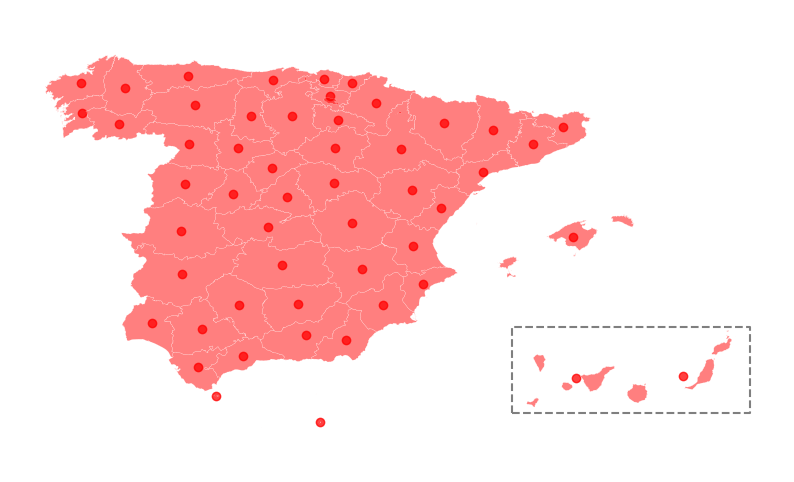

In [178]:
fig, ax = plt.subplots(figsize=(10, 6))
for j, shape in enumerate(spain_map["geometry"]):
    if spain_map["name"][j] == "Santa Cruz de Tenerife" or spain_map["name"][j] == "Las Palmas":
        shape = shapely.affinity.translate(shape, xoff=20, yoff=8)
    xc, yc = shape.centroid.x, shape.centroid.y
    ax.plot([xc], [yc], marker='o', color="r", alpha=0.75)
    for geom in shape.geoms:    
        xs, ys = geom.exterior.xy    
        ax.fill(xs, ys, alpha=0.5, fc='r')
        ax.plot(xs, ys, color="w", lw=0.2, alpha=0.5)
        xc, yc = geom.centroid.x, geom.centroid.y
ax.plot([1.5, 7, 7, 1.5, 1.5], [35.5, 35.5, 37.5, 37.5, 35.5], ls='--', c="k", alpha=0.5)
ax.axis('equal')
ax.axis('off')
